# Density Estimator for scRNA-seq Data

This notebook provides a guide to applying the Mellon density estimator on single-cell RNA sequencing (scRNA-seq) data. The objective of this tutorial is to illustrate the steps needed to execute a density estimation using the Mellon package. By the end of this notebook, you should have a solid understanding of how to use Mellon in your data analysis.

The following packages need to be installed for using Mellon with single-cell RNA-seq data:
1. `scanpy`: https://scanpy.readthedocs.io/en/stable/installation.html
2. `palantir`: https://github.com/dpeerlab/Palantir. We recommend installation using `pip install git+https://github.com/dpeerlab/Palantir`

Installation of these packages will install all the necessary dependencies for Mellon 

Let's now load all the necessary libraries.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


We are also setting some plot preferences and suppressing the NumbaDeprecationWarning for a cleaner output.

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 125
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"

import logging

logging.getLogger("matplotlib.font_manager").disabled = True

## Step 1: Reading and Displaying the Dataset

We will start by loading the scRNA-seq dataset. For this demonstration, we will use the preprocessed T-cell depleted bone marrow data as described in the Mellon manuscript.

In [3]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm-rna.h5ad"
ad = sc.read("data/preprocessed_t-cell-depleted-bm-rna.h5ad", backup_url=ad_url)
ad

  0%|          | 0.00/2.33G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

Note: The annData object `ad` we loaded already has been processed from raw gene counts according to the following [notebook](https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb), and comes with cell-type annotations, PCA, and a UMAP representation. The anndata object also contains primed and lineage specific accessibility scores.

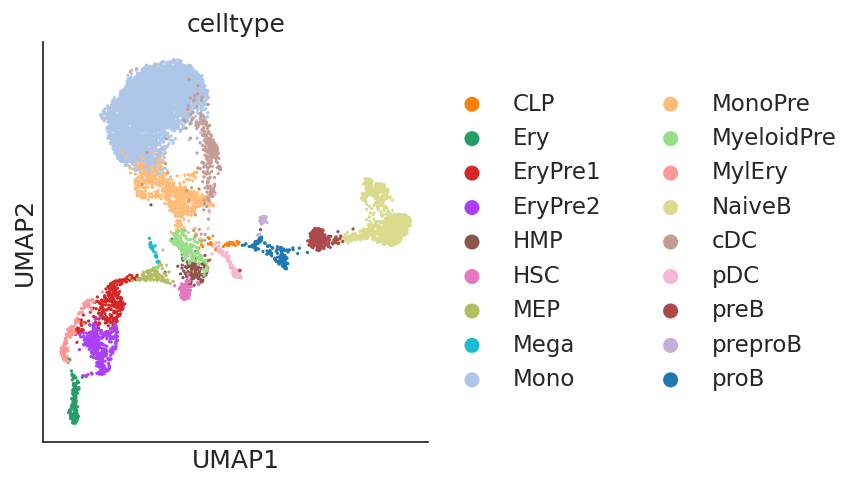

In [4]:
sc.pl.scatter(ad, basis="umap", color="celltype")

## Step 2: Preprocessing

We will use diffusion maps for cell-state representation as input to Mellon. Diffusion map captures the intrinsic geometry of the data by creating a reduced dimensional representation that maintains the relationships between cells. Diffusion maps can be computed using the `palantir.utils.run_diffusion_maps` function. This function uses the pre-computed `pca` by default but can be changed to utilize any `obsm` entry in the anndata object.

In [5]:
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca", n_components=20)

Determing nearest neighbor graph...


## Step 3: Density Calculation

In this step, we will compute cell-state density using Mellon's
[DensityEstimator](https://mellon.readthedocs.io/en/latest/model.html#mellon.model.DensityEstimator)
class. Diffusion components computed above serve as inputs.

The compute densities, `log_density` can  be visualized using UMAPs. We recommend the visualization of clipped log density. This procedure, which
trims the very low density of outlier cells to the lower 5% percentile, provides richer visualization in 2D embeddings such as UMAPs.

In [6]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

predictor = model.predict

ad.obs["mellon_log_density"] = log_density
ad.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2023-07-03 11:58:43,169] [INFO    ] Computing nearest neighbor distances.


2023-07-03 11:58:43.166702: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[2023-07-03 11:58:44,084] [INFO    ] Using covariance function Matern52(ls=0.007927411445308372).
[2023-07-03 11:58:44,086] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-07-03 11:58:47,098] [INFO    ] Doing low-rank Cholesky decomposition for 8,627 samples and 5,000 landmarks.
[2023-07-03 11:58:53,083] [INFO    ] Using rank 5,000 covariance representation.


/home/msetty/micromamba/envs/mellon-test-with-instructions/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[2023-07-03 11:58:56,333] [INFO    ] Running inference using L-BFGS-B.
[2023-07-03 11:59:08,868] [INFO    ] Computing predictive function.
CPU times: user 1min 1s, sys: 36.1 s, total: 1min 37s
Wall time: 27.9 s


In [7]:
# The anndata object is updated with `obs['log_density`]` and `obs['log_density_clipped']
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

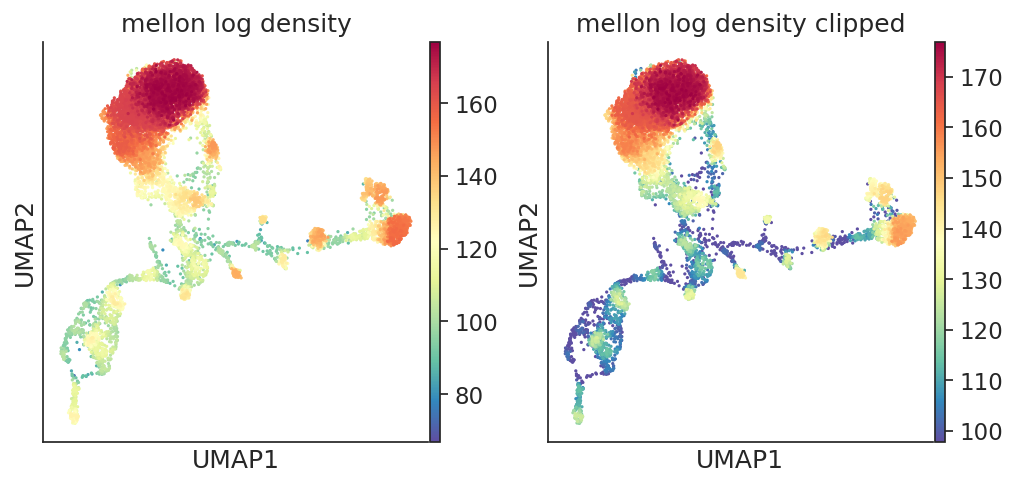

In [8]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

## Step 4: Analysis

Next, we can use the calculated cell densities to analyze different cell types in the dataset.

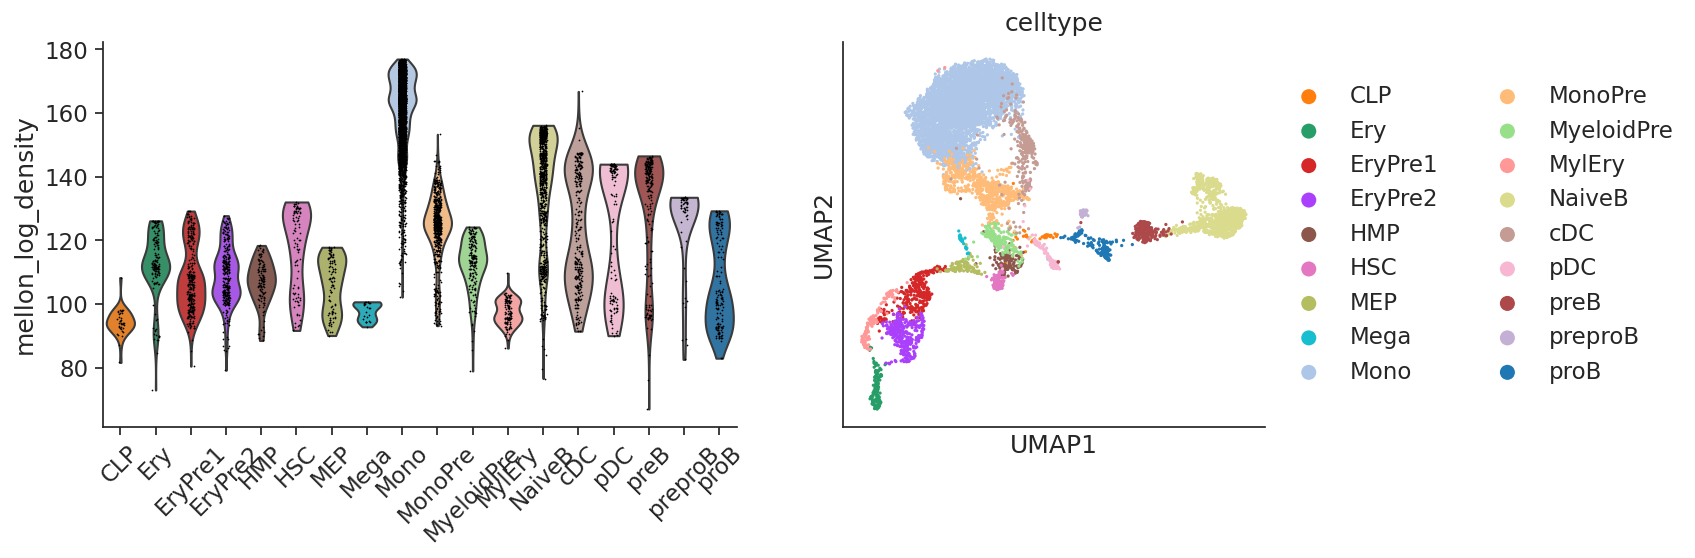

In [9]:
matplotlib.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])
sc.pl.violin(ad, "mellon_log_density", "celltype", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="celltype", basis="umap", ax=ax2, show=False)
plt.show()
matplotlib.rcParams["figure.figsize"] = [4, 4]

### Comparison of density along pseudotime

Density can compared against pseudotime or other axes to identify high- and low- density regions. The `ad` object contains palantir pseudotime in `ad.obs['palantir_pseudotime]` and the cells that belong to each lineage in `ad.obsm['palantir_lineage_cells']`. The identification of lineage cells is based on palantir probabilities and is detailed in the Palantir tutorial (https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb)[here].

In [10]:
ad.obs["palantir_pseudotime"], ad.obsm["palantir_lineage_cells"]

(IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1    0.138621
 IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1    0.336803
 IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1    0.684445
 IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1    0.311772
 IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1    0.704443
                                                                ...   
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1    0.309793
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1    0.306938
 IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1    0.311873
 IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1    0.312016
 IM-1393_BoneMarrow_TcellDep_2_multiome#AGACAATAGGCTCATG-1    0.311489
 Name: palantir_pseudotime, Length: 8627, dtype: float64,
                                                     NaiveB    Ery    pDC  \
 IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGA...   False  False  False   
 IM-139

We will explore the density along B-cell lineage

(<Figure size 500x500 with 1 Axes>, <Axes: >)

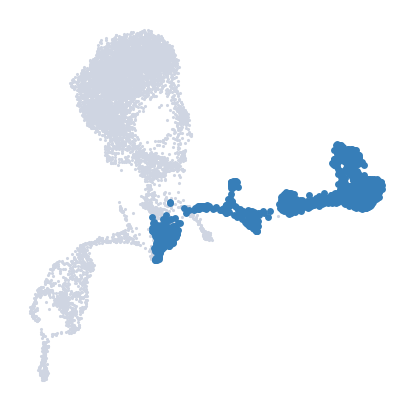

In [11]:
bcell_lineage_cells = ad.obs_names[ad.obsm["palantir_lineage_cells"]["NaiveB"]]

palantir.plot.highlight_cells_on_umap(ad, bcell_lineage_cells)

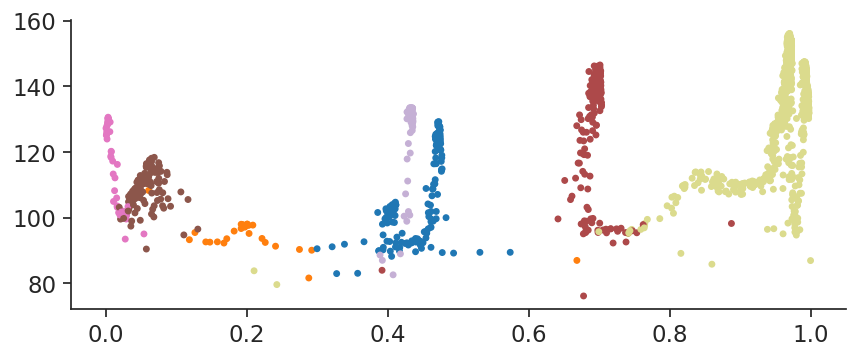

In [12]:
import pandas as pd

ct_colors = pd.Series(
    ad.uns["celltype_colors"], index=ad.obs["celltype"].values.categories
)

plt.figure(figsize=[8, 3])
plt.scatter(
    ad.obs["palantir_pseudotime"][bcell_lineage_cells],
    ad.obs["mellon_log_density"][bcell_lineage_cells],
    s=10,
    color=ct_colors[ad.obs["celltype"][bcell_lineage_cells]],
)

`palantir.plot.plot_branch` provides this plotting functionality (and  more!) following the plotting style of `scanpy`

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'NaiveB'}, xlabel='Pseudotime', ylabel='mellon_log_density'>)

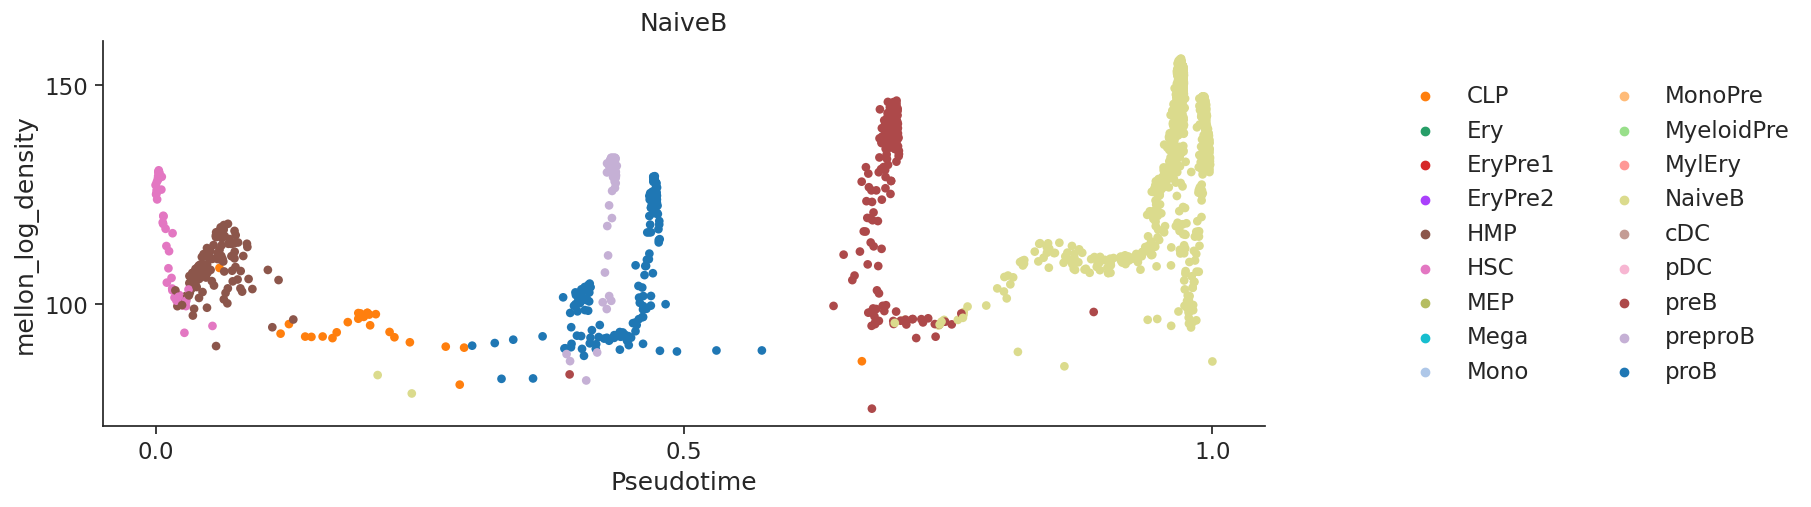

In [13]:
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="celltype",
    masks_key="palantir_lineage_cells",
    s=100,
)

This plot clearly illustrates the alternating high- and low- density regions that define B-cell differentiation. This variability can be examined to identify high- and low-density regions

The same function can be used to visualize gene expression

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'NaiveB'}, xlabel='Pseudotime', ylabel='mellon_log_density'>)

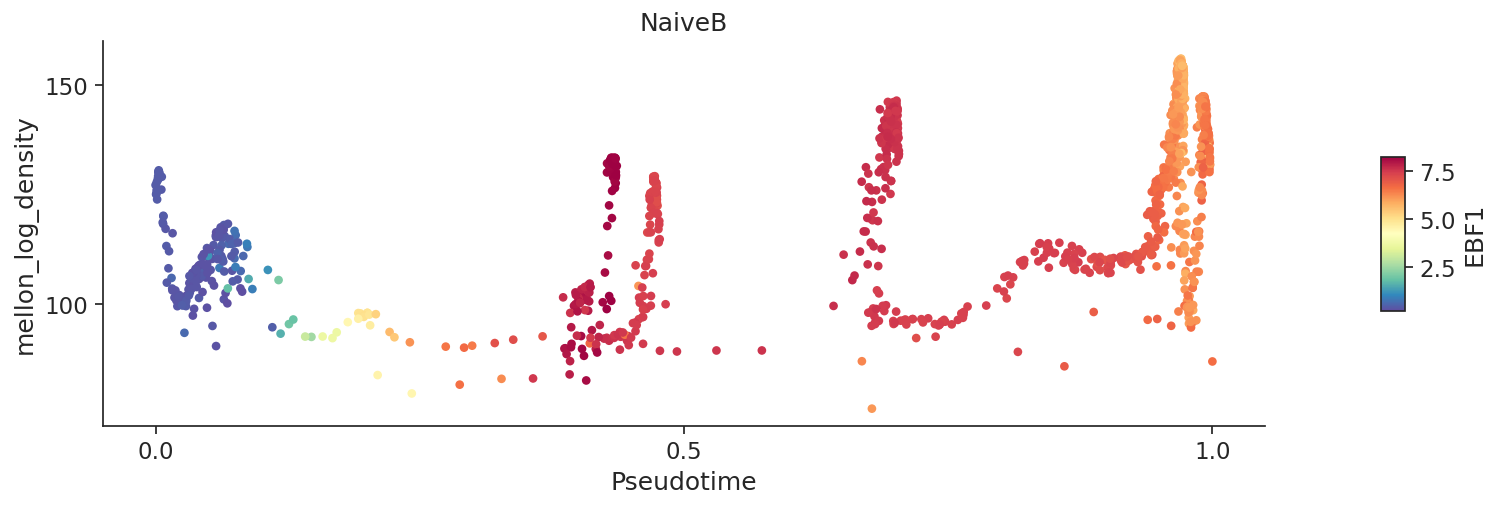

In [14]:
# Plot imputed expressino of EBF1 in the comparison between pseudotime and log density
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="MAGIC_imputed_data",
    masks_key="palantir_lineage_cells",
    s=100,
)

### Local variability or local change in expression

Local variability provides a measure of gene expression change for each cell-state. This is determined by comparison of a gene in a cell to its neighbor cell-states and can be computed using `palantir.utils.run_local_variability`


In [15]:
# Local variability of genes
palantir.utils.run_local_variability(ad)

# This will add `local_variability` as a layer to anndata
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data', 'local_variability'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivitie

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'NaiveB'}, xlabel='Pseudotime', ylabel='mellon_log_density'>)

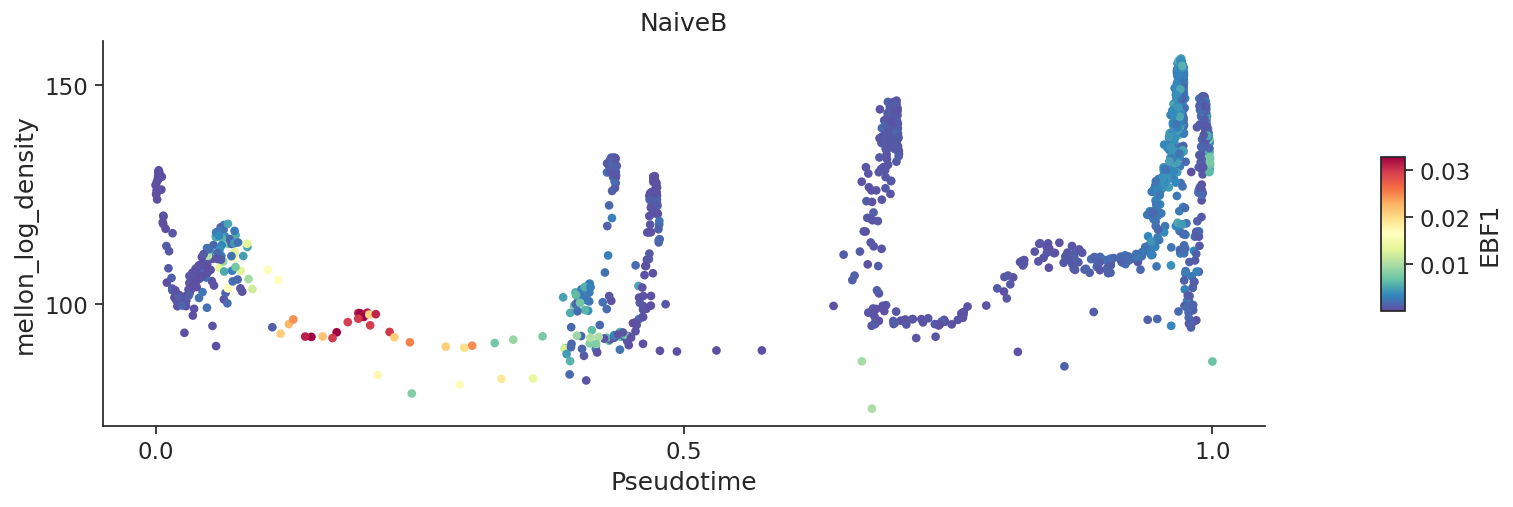

In [16]:
# Local variability or local change can also be visualized using `plot_branch` function
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="local_variability",
    masks_key="palantir_lineage_cells",
    s=100,
)

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'NaiveB'}, xlabel='Pseudotime', ylabel='mellon_log_density'>)

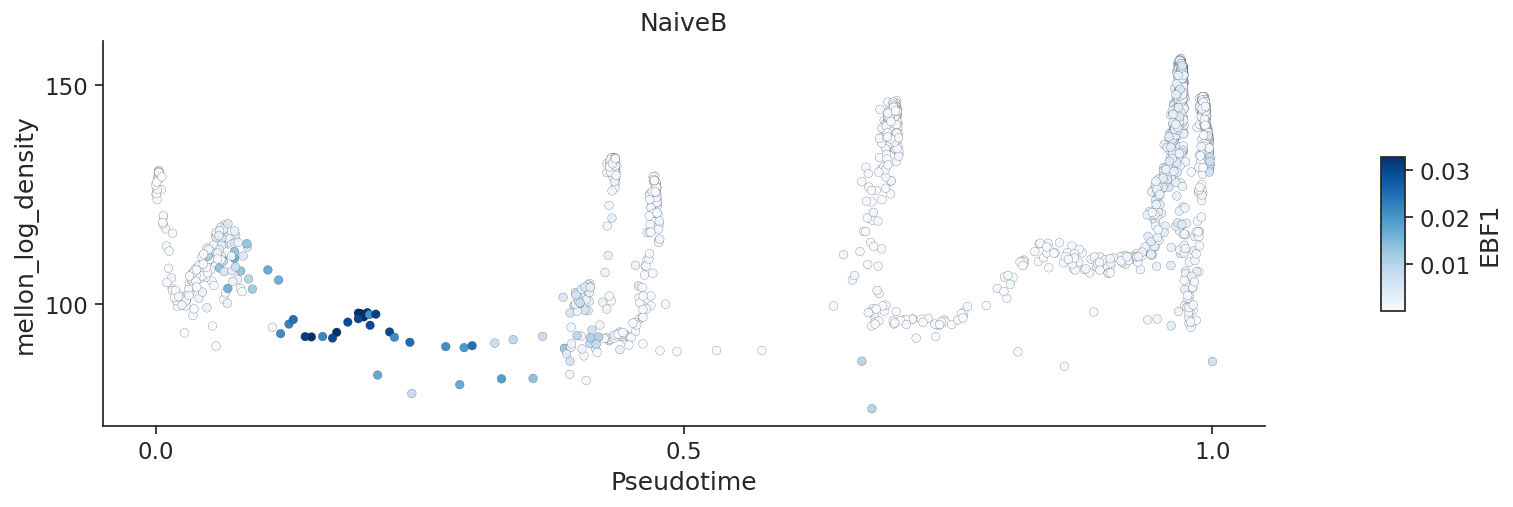

In [17]:
# In the Mellon manuscript, we use the Blues colormap for plotting changes
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="local_variability",
    masks_key="palantir_lineage_cells",
    s=100,
    cmap=matplotlib.cm.Blues,
    edgecolor="black",
    linewidth=0.1,
)

/home/msetty/micromamba/envs/mellon-test-with-instructions/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


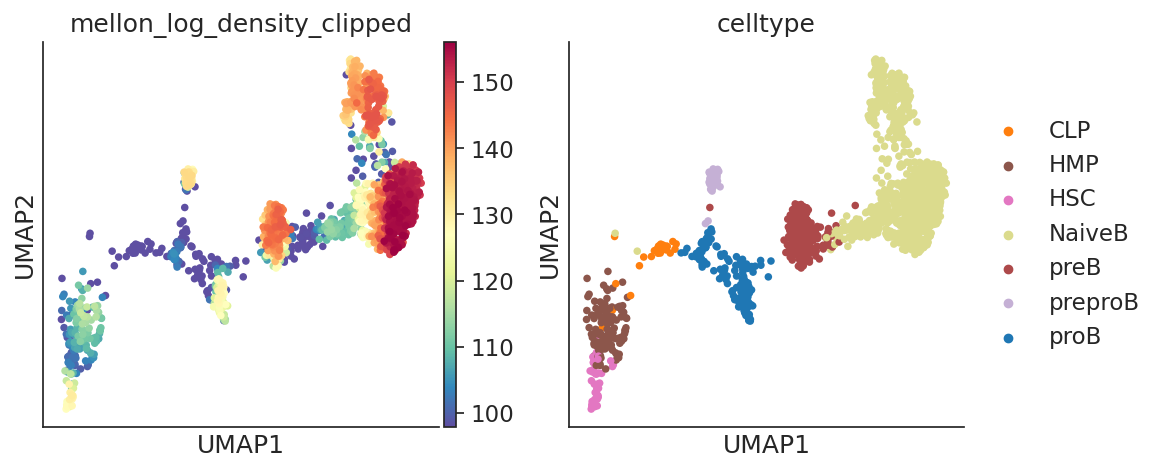

In [18]:
# UMAPs can be plotted with subsets of cells to explore densiies
sc.pl.embedding(
    ad[bcell_lineage_cells],
    basis="umap",
    color=["mellon_log_density_clipped", "celltype"],
)

## Step 5: Saving and Loading the Predictor

The predictor can be serialized to a dictionary and saved directly within the Anndata object. We can then write the Anndata object to disk, reload it, reconstitute the predictor from the saved dictionary, and apply it to our data. The final check verifies that the deserialized density function is identical to the original.

In [19]:
# Convert to dictionary and save to Anndata, then write Anndata to disk
ad.uns["log_density_function"] = predictor.to_dict()
ad.write("data/adata.h5ad")

# Reload Anndata and reconstitute predictor
ad = sc.read("data/adata.h5ad")
predictor = mellon.Predictor.from_dict(ad.uns["log_density_function"])

# Apply loaded predictor and verify it's identical to original
log_density = predictor(ad.obsm["DM_EigenVectors"])
assert np.all(
    np.isclose(log_density, ad.obs["mellon_log_density"])
), "Deserialized density function differs from original."

Alternatively, you can directly serialize the predictor to disk, bypassing the Anndata step.

In [20]:
# Serialize the predictor to a JSON file
predictor.to_json("data/density_predictor.json")

# Load the predictor from the JSON file
loaded_predictor = mellon.Predictor.from_json("data/density_predictor.json")

# Apply the loaded predictor on any data
log_density = loaded_predictor(ad.obsm["DM_EigenVectors"])

[2023-07-03 12:00:11,831] [INFO    ] Written predictor to data/density_predictor.json.


# Advanced Applications

Mellon offers access to all its intermediate results, giving you the flexibility to supply your own versions. For example, you can provide specific landmark cell states or parameters, opt out from relying on the built-in heuristics, or employ your preferred optimizer. Even custom Bayesian inference schemes can be used on the log-posterior probability for the final inference.

## Tunable Parameters

Mellon's architecture facilitates a customizable approach to cell density computation, providing numerous tunable parameters for model refinement. This adaptability allows you to tailor the model to the unique demands of your dataset. In the following section, we will explore some of these parameters in greater detail.

In [21]:
X = ad.obsm["DM_EigenVectors"]
nn_distances = mellon.parameters.compute_nn_distances(X)

The `length_scale` parameter determines the smoothness of the resulting density function. A lower value leads to a more detailed, but less stable, density function. By default, Mellon calculates the length scale based on a heuristic to maximize the posterior likelihood of the resulting density function.

In [22]:
length_scale = mellon.parameters.compute_ls(nn_distances)

Landmarks in the data are used to approximate the covariance structure and hence the similarity of density values between cells by using the similarity to the landmarks as proxy. K-means clustering centroids usually provide good landmarks. The number of landmarks limits the rank of the covariance matrix.

In [23]:
%%time
n_landmarks = 5000
landmarks = k_means(X, n_landmarks, n_init=1)[0]

CPU times: user 23 s, sys: 17.8 s, total: 40.8 s
Wall time: 2.8 s


You can further reduce the rank of the covariance matrix using an improved Nyström approximation. The `rank` parameter allows you to set either the fraction of total variance (sum of eigenvalues) preserved or a specific number of ranks.

In [24]:
%%time
rank = 0.999
cov_func = mellon.cov.Matern52(length_scale)
L = mellon.parameters.compute_L(X, cov_func, landmarks=landmarks, rank=rank)

[2023-07-03 12:00:17,529] [INFO    ] Doing low-rank improved Nyström decomposition for 8,627 samples and 5,000 landmarks.
[2023-07-03 12:00:39,920] [INFO    ] Recovering 99.900238% variance in eigendecomposition.
CPU times: user 3min 52s, sys: 1min 3s, total: 4min 55s
Wall time: 23.3 s


The `d` parameter denotes the dimensionality of the local variation in cell states and by default we assume that the data can vary along all its dimensions. However, if it is known that locally cells vary only along a subspace, e.g., tangential to the phenotypic manifold, then the dimensionality of this subspace should be used. d is used to correctly related the nearest-neighbor-distance distribution to the cell-state density.

In [25]:
d = X.shape[1]

Mellon can automatically suggest a mean value mu for the Gaussian process of log-density to ensure scale invariance. A low value ensures that the density drops of quickly away from the data.

In [26]:
mu = mellon.parameters.compute_mu(nn_distances, d)

An initial value, based on ridge regression, is used by default to speed up the optimization.

In [27]:
%%time
initial_parameters = mellon.parameters.compute_initial_value(nn_distances, d, mu, L)

model = mellon.DensityEstimator(
    nn_distances=nn_distances,
    d=d,
    mu=mu,
    cov_func=cov_func,
    L=L,
    initial_value=initial_parameters,
)

log_density = model.fit_predict(X)

[2023-07-03 12:00:41,459] [INFO    ] Computing 5,000 landmarks with k-means clustering.


/home/msetty/micromamba/envs/mellon-test-with-instructions/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[2023-07-03 12:00:44,238] [INFO    ] Running inference using L-BFGS-B.
CPU times: user 32.4 s, sys: 19.1 s, total: 51.5 s
Wall time: 9.28 s


## Stages API

Instead of fitting the model with the fit function, you may split training into
three stages: prepare_inference, run_inference, and process_inference.

In [28]:
model = mellon.DensityEstimator()
model.prepare_inference(X)
model.run_inference()
log_density_x = model.process_inference()

[2023-07-03 12:00:50,205] [INFO    ] Computing nearest neighbor distances.
[2023-07-03 12:00:50,831] [INFO    ] Using covariance function Matern52(ls=0.007927411445308372).
[2023-07-03 12:00:50,833] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-07-03 12:00:53,577] [INFO    ] Doing low-rank Cholesky decomposition for 8,627 samples and 5,000 landmarks.
[2023-07-03 12:00:58,190] [INFO    ] Using rank 5,000 covariance representation.


/home/msetty/micromamba/envs/mellon-test-with-instructions/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[2023-07-03 12:01:01,210] [INFO    ] Running inference using L-BFGS-B.
[2023-07-03 12:01:13,722] [INFO    ] Computing predictive function.


This offers the flexibility to make interim modifications. For instance, should you wish to utilize your own optimizer, you can replace `run_inference` with it, using the I/O from the three stages as follows:

```python
def optimize(loss_func, initial_parameters):
    ...
    return optimal_parameters

model = mellon.DensityEstimator()
loss_func, initial_parameters = model.prepare_inference(X)
pre_transformation = optimize(loss_func, initial_parameters)
log_density_x = model.process_inference(pre_transformation=pre_transformation)
```

Note that `loss_func` represents the negative log posterior likelihood of the latent density function representation. Hence, it can be incorporated into custom Bayesian inference schemes aiming to infer a posterior distribution of density functions, including the uncertainty of their values.

## Derivatives

After inference the density and its derivatives can be computed for arbitrary cell-states.

In [29]:
%%time
gradients = predictor.gradient(X)
hessians = predictor.hessian(X)

CPU times: user 13.1 s, sys: 7.23 s, total: 20.4 s
Wall time: 3.22 s
